In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm


# Define a simple 5-layer CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256)
        x = self.fc1(x)
        return x

    
device = 'cuda:0'
batch_size = 128

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Load and normalize MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the network
num_epochs = 3

In [3]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
def train(num_epochs=2, seed=42):
    seed_all(seed)
    print(f'Set seed={seed}')
    net = SimpleCNN()
    net = net.to(device)
    
    optimizer = optim.AdamW(net.parameters(), lr=3e-4)
    epoch_losses = []
    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / ((i + 1))
        epoch_losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")


    print("Training completed.")

    # Plot the training loss curve
    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # Test the network
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the 10,000 test images: {100 * correct / total}%")
    return net

# Train two networks

Set seed=0


  0%|          | 0/5 [00:00<?, ?it/s]

Training completed.


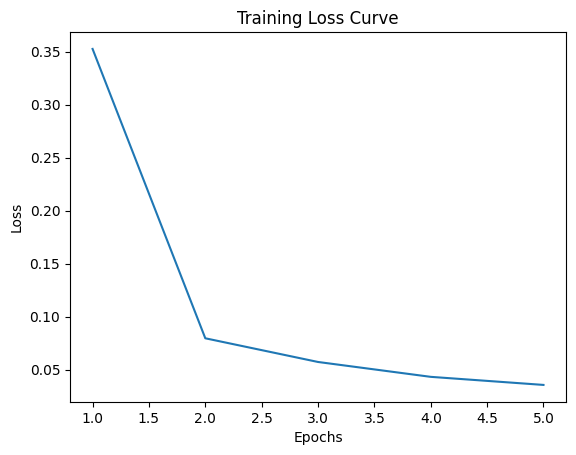

Accuracy on the 10,000 test images: 98.97%


In [7]:
model0 = train(seed=0, num_epochs=5)

Set seed=1


  0%|          | 0/2 [00:00<?, ?it/s]

Training completed.


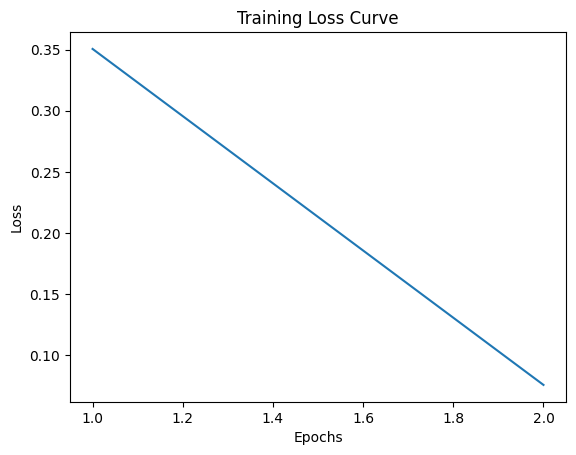

Accuracy on the 10,000 test images: 98.22%


In [8]:
model1 = train(seed=1, num_epochs=2)

# Learn to manipulate the weights

In [11]:
from collections import OrderedDict


def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def params2vec(state_dict):
    state_dict_shapes = OrderedDict()
    params = []

    for name, p in state_dict.items():
        state_dict_shapes[name] = p.shape
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, state_dict_shapes

def vec2params(param_vec, state_dict_shapes):
    offset = 0
    reconstructed_state_dict = OrderedDict()

    for name, shape in state_dict_shapes.items():
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_state_dict[name] = p

        offset += n

    return reconstructed_state_dict

In [14]:
param_vec0, state_dict_shapes = params2vec(model0.state_dict())
param_vec0

tensor[390410] x∈[-0.456, 0.430] μ=-0.001 σ=0.027 cuda:0

In [36]:
model0_reconstructed = SimpleCNN().to(device)
model0_reconstructed.load_state_dict(vec2params(param_vec0, state_dict_shapes))

<All keys matched successfully>

In [41]:
rand_input = torch.randn(32, 1, 28, 28).to(device)
out0 = model0(rand_input)

In [42]:
out0_rec = model0_reconstructed(rand_input)

In [43]:
assert torch.allclose(out0, out0_rec)

In [45]:
param_vec1, state_dict_shapes = params2vec(model1.state_dict())
param_vec1

tensor[390410] x∈[-0.394, 0.388] μ=0.000 σ=0.025 cuda:0

# Setup the optimization problem

## Ensure path (weight vector -> loss on MNIST) is differentiable

# Train two networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [2]:
device = 'cuda:0'
batch_size = 128

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Load and normalize MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the network
num_epochs = 3

In [3]:
import torch
import torch.nn.functional as F

def kaiming_init(tensor):
    fan_in = tensor.shape[1]
    gain = torch.nn.init.calculate_gain('relu')
    std = gain / torch.sqrt(torch.tensor(fan_in, dtype=torch.float32))
    return tensor.normal_(0, std.item())

class RawSimpleCNN:
    def __init__(self):
        # Initialize weights and biases using Kaiming initialization
        self.W1 = kaiming_init(torch.empty(32, 1, 3, 3))
        self.b1 = torch.zeros(32)
        self.W2 = kaiming_init(torch.empty(64, 32, 3, 3))
        self.b2 = torch.zeros(64)
        self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
        self.b3 = torch.zeros(128)
        self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
        self.b4 = torch.zeros(256)
        self.W_fc1 = kaiming_init(torch.empty(10, 256))
        self.b_fc1 = torch.zeros(10)

        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W_fc1, self.b_fc1]
        for p in self.parameters:
            p.requires_grad=True
        
        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        W1, b1, W2, b2, W3, b3, W4, b4, W_fc1, b_fc1 = params

        x = F.conv2d(x, W1, b1, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W2, b2, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W3, b3, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W4, b4, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 256)

        x = F.linear(x, W_fc1, b_fc1)

        return x

def parameters_to_simple_cnn(params):
    model = SimpleCNN()
    model.conv1.weight.data.copy_(params[0])
    model.conv1.bias.data.copy_(params[1])
    model.conv2.weight.data.copy_(params[2])
    model.conv2.bias.data.copy_(params[3])
    model.conv3.weight.data.copy_(params[4])
    model.conv3.bias.data.copy_(params[5])
    model.conv4.weight.data.copy_(params[6])
    model.conv4.bias.data.copy_(params[7])
    model.fc1.weight.data.copy_(params[8].t())
    model.fc1.bias.data.copy_(params[9])

    return model

# Test the raw_forward function
raw_net = RawSimpleCNN().to(device)

In [4]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def net2params(raw_net):
    params_shapes = []
    params = []

    for p in raw_net.parameters:
        params_shapes.append( p.shape )
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, params_shapes

In [6]:
def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def reconstruct_params(param_vec, params_shapes):
    offset = 0
    reconstructed_params = []

    for shape in params_shapes:
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_params.append(p)

        offset += n
        
    return reconstructed_params

In [7]:
def param_vec2net(param_vec, params_shapes):
    params = reconstruct_params
    raw_net = RawSimpleCNN()
    
    reconstructed_params = reconstruct_params(param_vec, params_shapes)
    raw_net.parameters = reconstructed_params
    return raw_net

In [8]:
def train(num_epochs=2, seed=42):
    seed=42
    seed_all(seed)
    print(f'Set seed={seed}')

    param_vec, params_shapes = net2params(RawSimpleCNN())
    param_vec = param_vec.detach().to(device)
    param_vec.requires_grad = True

    optimizer = optim.AdamW([param_vec], lr=3e-4)
    epoch_losses = []
    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            raw_net = param_vec2net(param_vec, params_shapes)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = raw_net.raw_forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print(loss.item())

            running_loss += loss.item()

        avg_loss = running_loss / ((i + 1))
        epoch_losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")


    print("Training completed.")

    # Plot the training loss curve
    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # Test the network
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the 10,000 test images: {100 * correct / total}%")
    return param_vec, params_shapes

Set seed=42


  0%|          | 0/2 [00:00<?, ?it/s]

Training completed.


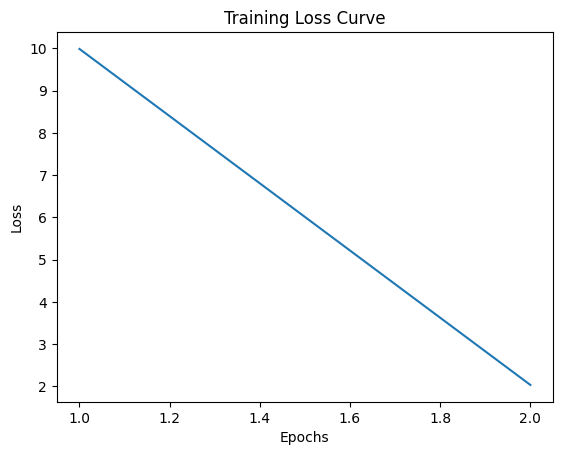

Accuracy on the 10,000 test images: 94.62%


In [9]:
param_vec2, params_shapes = train(num_epochs=2, seed=2)

Set seed=42


  0%|          | 0/5 [00:00<?, ?it/s]

Training completed.


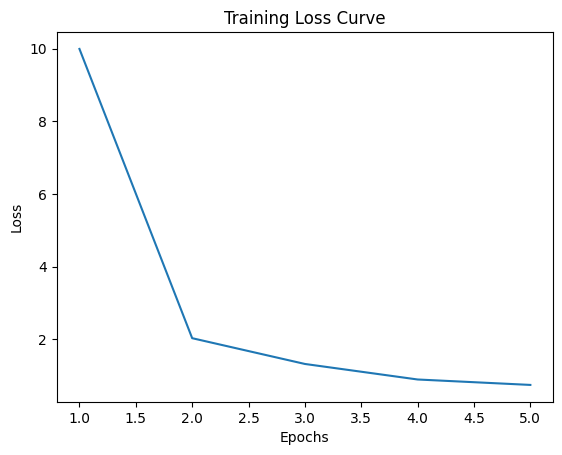

Accuracy on the 10,000 test images: 95.56%


In [10]:
param_vec3, params_shapes = train(num_epochs=5, seed=3)

In [11]:
def evaluate_loss(param_vec, verbose=False):
    loss = 0.
    n_images = 0
    correct = 0
    with torch.inference_mode():

        raw_net = param_vec2net(param_vec, params_shapes)

        for i, data in zip(range(1), testloader):
            images, labels = data

            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)

            batch_loss = criterion(outputs, labels)
            loss += batch_loss

            _, predicted = torch.max(outputs.data, 1)
            # print('predicted',predicted)
            n_images += labels.size(0)
            correct += (predicted == labels).sum().item()

    if verbose:
        print(f"Loss={loss} | Accuracy on the {n_images} test images: {100 * correct / n_images}%")
    return loss

# Vizualize simple loss surface

In [12]:
def cos(a, b): return a.dot(b)/(a.norm() * b.norm() + 1e-6)

## Orthogonolization process 

I need to:

1. loss(w1 + u) == loss(w2)
1. loss(w1 + xu + yv) == loss(w3)

where $x,y$ - coordinates of w3 in new frame. How do I find them?

First, I need to answer you how do I find $v$.

In [13]:
u, v = param_vec2, param_vec3
w1 = torch.zeros_like(u)

u = u - w1
v = v - w1

y = cos(u,v)
v = v - y * u

# v = F.normalize(v, dim=0)
normal_u, normal_v = F.normalize(u, dim=0), F.normalize(v, dim=0)
norm_of_u, norm_of_v = u.norm(), v.norm()

In [14]:
evaluate_loss(w1), evaluate_loss(param_vec2).item(), evaluate_loss(param_vec3).item()

(tensor cuda:0 2.303, 1.0273975133895874, 1.530634880065918)

In [15]:
assert torch.allclose ( evaluate_loss(w1 + u), evaluate_loss(param_vec2) )

In [16]:
assert torch.allclose(evaluate_loss(w1 + y*u + v), evaluate_loss(param_vec3))

In [17]:
max_range = max(norm_of_u, norm_of_v).item() * 2.
max_range

185.99732971191406

In [18]:
x2,y2 = norm_of_u, 0
x3,y3 = norm_of_u*y, norm_of_v

In [19]:
assert torch.allclose ( evaluate_loss(w1 + x2*normal_u + y2*normal_v), evaluate_loss(param_vec2) )

In [20]:
assert torch.allclose ( evaluate_loss(w1 + x3*normal_u + y3*normal_v), evaluate_loss(param_vec3) )

In [131]:
n = 20
losses = torch.empty(n,n)

arange = torch.linspace(-max_range, max_range, n).numpy()
for i_int, i in enumerate(tqdm(arange)):
    for j_int, j in enumerate(arange):
        w = w1 + i*normal_u + j*normal_v
        loss = evaluate_loss(w)
        losses[i_int,j_int] = loss.item()

  0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fd8449733b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 1698590) exited unexpectedly

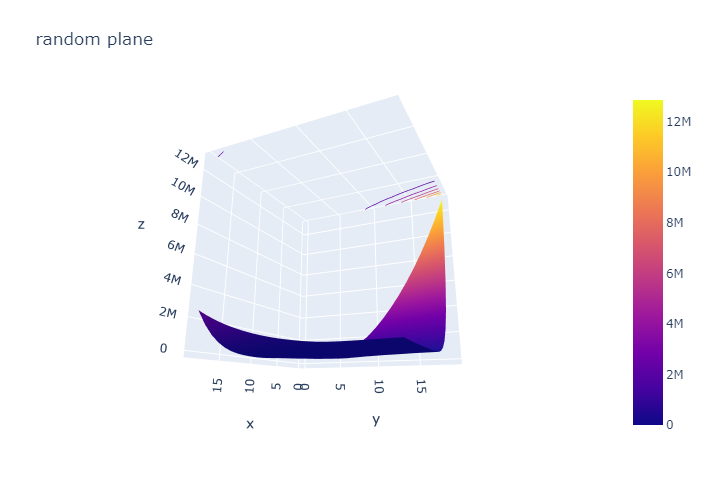

In [124]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=losses)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='random plane', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

# Mode connectivity

$\phi$

tensor grad MeanBackward0 cuda:0 -0.001

In [21]:
class BezierConnectome:
    def __init__(self, w1, w2):
        self.theta = torch.randn_like(w1) * w1.std()

        self.w1 = w1
        self.w2 = w2
        
    def phi(self, t):
        return (1-t**2)*self.w1 + 2*t*(1.-t)*self.theta + t**2*self.w2

In [22]:
w2, w3 = param_vec2, param_vec3

In [23]:
connectome = BezierConnectome(w2, w3)

In [29]:
connectome.theta = connectome.theta.detach()
connectome.theta.requires_grad=True
optimizer = optim.AdamW([connectome.theta], lr=3e-4)

In [30]:
connectome.theta

tensor[390410] x∈[-0.675, 0.710] μ=3.842e-05 σ=0.149 grad cuda:0

In [31]:
def loss_for_w(w):
    loss = 0.
    n_images = 0
    correct = 0

    raw_net = param_vec2net(w, params_shapes)

    for i, data in zip(range(1), testloader):
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = raw_net.raw_forward(images)

        batch_loss = criterion(outputs, labels)
        loss += batch_loss

        _, predicted = torch.max(outputs.data, 1)
        # print('predicted',predicted)
        n_images += labels.size(0)
        correct += (predicted == labels).sum().item()
    return loss

In [37]:
cbs = 12

In [38]:
for _ in range(100):
    ts = torch.rand(cbs, 1, device=device)
    ws = connectome.phi(ts)
    loss = 0
    for w in ws:
        loss = loss + loss_for_w(w)
    
    print(f'{loss:.5f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

3.70085
1.89647
2.58941
1.75290
1.05252
1.34788
1.94010
0.30396
0.51931
1.87882
0.65800
0.61163
1.02242
0.04798
0.01042
1.09038
0.38108
0.00053
1.78176
0.73356
1.40971
1.13814
0.12046
0.00006
2.23106
0.55537
1.29003
1.08578
1.34089
0.00035
0.00047
0.42348
0.33360
0.12253
0.94517
1.18057
0.87772
0.00621
1.97251
0.88623
1.14025
0.26269
1.30763
0.00492
1.17534
0.02095
1.01326
2.31913
0.00372
0.00190
0.58971
0.62936
0.01317
0.75049
0.78613
0.03516
0.00118
0.82841
1.09454
0.80636
1.95494
0.52313
0.00071
0.95274
0.43409
0.12417
0.53067
1.26781
0.89439
0.00270
1.66332
0.06172
0.30212
0.00023
0.10197
1.99159
0.00487
0.00793
0.50021
0.02234
0.02038
0.00114
0.00011
2.36480
2.20896
0.89257
0.00440
0.95754
0.66667
0.00848
1.94259
0.96157
0.00011
0.07288
1.42177
0.59764
0.00018
0.86798
0.00017
0.79606


In [39]:
u, v = param_vec2, param_vec3
w1 = connectome.theta

u = u - w1
v = v - w1

y = cos(u,v)
v = v - y * u

# v = F.normalize(v, dim=0)
normal_u, normal_v = F.normalize(u, dim=0), F.normalize(v, dim=0)
norm_of_u, norm_of_v = u.norm(), v.norm()